In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf

In [2]:
from maskrcnn.postprocess.validate import gini

In [3]:
VIL_SHP_IN_DIR = 'data/Shapefile/GDVillageShapefile/GE_GD_villages_ConvexHull.shp'
CENSUS_IN_DIR = 'data/GiveDirectly/Survey/GE_HH_Census_2017-07-17_cleanGPS.csv'
SAT_IN_GEOM_DIR = 'data/Experiment4/sat.geojson'
MERGE_IN_DIR = 'data/Experiment4/village_merged.csv'

OUT_DIR = 'data/Experiment4/output/'

## Treatment

In [4]:
df = gpd.read_file(VIL_SHP_IN_DIR)
# drop non GE villages
df = df.loc[df['ge'] == 1, :]
# convert data type for merging
df = df.astype({'village_co': 'Int64'})
df_village = df.loc[:, ['village_co', 'geometry']]

In [5]:
df = pd.read_csv(
    CENSUS_IN_DIR,
    usecols=['sublocation_code', 'village_code', 'ge', 'hi_sat', 'treat',
             'latitude', 'longitude', 'elevation', 'accuracy', 'eligible',
             'GPS_imputed', 'dist_from_vill'],
    dtype={
        'sublocation_code': 'Int64',
        'village_code': 'Int64',
        'ge': 'Int32',
        'hi_sat': 'Int32',
        'treat': 'Int32',
        'eligible': 'Int32',
        'GPS_imputed': 'Int32'})

In [6]:
df = df.loc[df['ge'] == 1, :]

In [7]:
df.loc[:, 'treat_eligible'] = df.loc[:, 'treat'].values * df.loc[:, 'eligible'].values

In [8]:
df_treat = df.groupby(['village_code', 'sublocation_code', 'hi_sat', 'treat']).agg(
    n_eligible=pd.NamedAgg(column='eligible', aggfunc='sum'),
    n_household=pd.NamedAgg(column='eligible', aggfunc='count'),
).reset_index()

In [9]:
df_treat = pd.merge(
    df_treat, df_village,
    how='outer', left_on='village_code', right_on='village_co')

In [10]:
df_treat = gpd.GeoDataFrame(df_treat, geometry='geometry', crs={'init': 'epsg:4326'})

## Satellite

In [11]:
df = gpd.read_file(SAT_IN_GEOM_DIR)
df.geometry = df.geometry.centroid

## Merge

In [12]:
df = gpd.sjoin(df_treat, df, how='left', op='contains')

In [13]:
df.columns

Index(['village_code', 'sublocation_code', 'hi_sat', 'treat', 'n_eligible',
       'n_household', 'village_co', 'geometry', 'index_right', 'angle', 'xmin',
       'ymin', 'width', 'height', 'R_mean', 'G_mean', 'B_mean', 'R_median',
       'G_median', 'B_median', 'redness', 'luminosity', 'saturation', 'area',
       'score', 'index', 'category_id'],
      dtype='object')

In [14]:
df = df.loc[:, [
    'village_code', 'sublocation_code', 'hi_sat', 'treat', 'n_eligible',
    'n_household', 'angle', 'R_mean', 'G_mean', 'B_mean', 'R_median',
    'G_median', 'B_median', 'luminosity', 'saturation', 'area', 'score']]

In [15]:
df.to_csv(MERGE_IN_DIR, index=False)

## Regresssion

In [16]:
df = pd.read_csv(MERGE_IN_DIR)

In [17]:
df = df.loc[df['score'] > 0.995, :]

In [18]:
df_village = df.groupby([
    'village_code', 'sublocation_code',
    'hi_sat', 'treat', 'n_eligible', 'n_household'
]).agg(
    house_count=pd.NamedAgg(column='area', aggfunc='count'),
    area_gini=pd.NamedAgg(column='area', aggfunc=gini),
    area_sum=pd.NamedAgg(column='area', aggfunc='sum'),
    luminosity=pd.NamedAgg(column='luminosity', aggfunc='mean'),
    luminosity_gini=pd.NamedAgg(column='luminosity', aggfunc=gini),
).reset_index()

In [19]:
df_village

,village_code,sublocation_code,hi_sat,treat,n_eligible,n_household,house_count,area_gini,area_sum,luminosity,luminosity_gini
0,601010101002,601010101,0,0,45,125,73,0.257051,92194.0,0.705050,0.089032
1,601010101004,601010101,0,0,18,80,72,0.318482,104086.0,0.700776,0.119205
2,601010101009,601010101,0,0,33,142,83,0.262065,119579.0,0.640503,0.129223
3,601010101010,601010101,0,1,46,115,93,0.264020,124666.0,0.641208,0.128312
4,601010102001,601010102,0,0,41,125,67,0.353584,118163.0,0.674466,0.122675
...,...,...,...,...,...,...,...,...,...,...,...
648,601050504005,601050504,0,1,38,128,65,0.278335,94053.0,0.669698,0.146196
649,601050504006,601050504,0,1,35,141,58,0.260101,80430.0,0.672938,0.118360
650,601050504007,601050504,0,0,32,85,25,0.201456,37551.0,0.670784,0.128912
651,601050504008,601050504,0,0,13,60,56,0.306392,97573.0,0.644485,0.159163


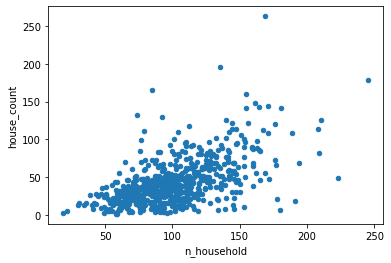

In [20]:
df_village.plot(x='n_household', y='house_count', kind='scatter')

In [21]:
mod = smf.ols(formula='house_count ~ treat', data=df_village)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            house_count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.299
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.130
Time:                        18:07:40   Log-Likelihood:                -3155.4
No. Observations:                 653   AIC:                             6315.
Df Residuals:                     651   BIC:                             6324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.7692      1.687     24.169      0.0

In [22]:
mod = smf.ols(formula='area_sum ~ treat', data=df_village)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               area_sum   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.163
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.281
Time:                        18:07:40   Log-Likelihood:                -7972.7
No. Observations:                 653   AIC:                         1.595e+04
Df Residuals:                     651   BIC:                         1.596e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.469e+04   2697.178     23.983      0.0

In [23]:
mod = smf.ols(formula='luminosity ~ treat', data=df_village)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             luminosity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     5.550
Date:                Tue, 31 Mar 2020   Prob (F-statistic):             0.0188
Time:                        18:07:41   Log-Likelihood:                 1028.9
No. Observations:                 653   AIC:                            -2054.
Df Residuals:                     651   BIC:                            -2045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6548      0.003    235.434      0.0

In [24]:
mod = smf.ols(formula='area_gini ~ treat', data=df_village)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              area_gini   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.004628
Date:                Tue, 31 Mar 2020   Prob (F-statistic):              0.946
Time:                        18:07:41   Log-Likelihood:                 981.38
No. Observations:                 653   AIC:                            -1959.
Df Residuals:                     651   BIC:                            -1950.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2411      0.003     80.605      0.0

In [25]:
mod = smf.ols(formula='luminosity_gini ~ treat', data=df_village)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        luminosity_gini   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.584
Date:                Tue, 31 Mar 2020   Prob (F-statistic):             0.0588
Time:                        18:07:41   Log-Likelihood:                 1236.7
No. Observations:                 653   AIC:                            -2469.
Df Residuals:                     651   BIC:                            -2460.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1298      0.002     64.139      0.0